In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, CartesianRepresentation, ICRS, GCRS,UnitSphericalRepresentation
# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


from pyipn import copy_template, Universe

<IPython.core.display.Javascript object>


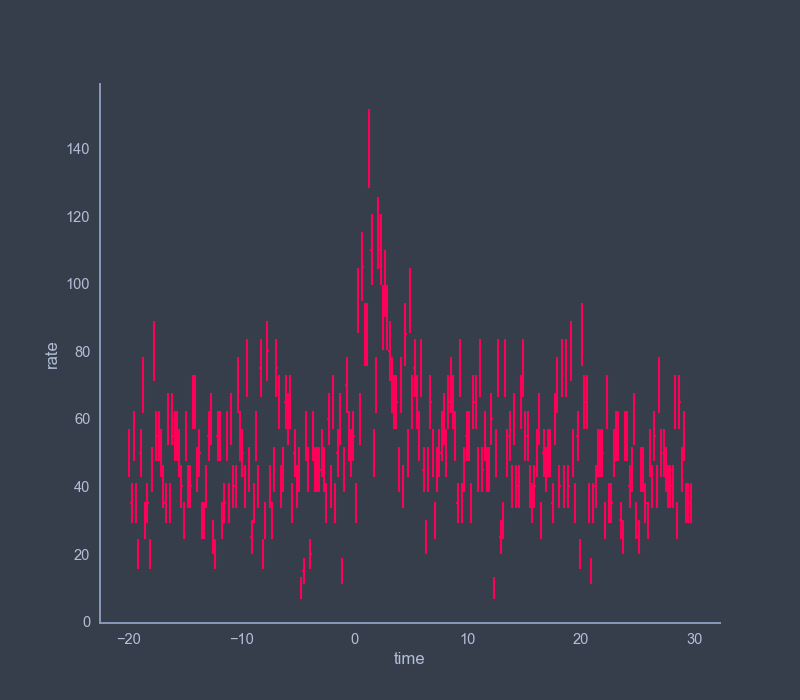

<IPython.core.display.Javascript object>


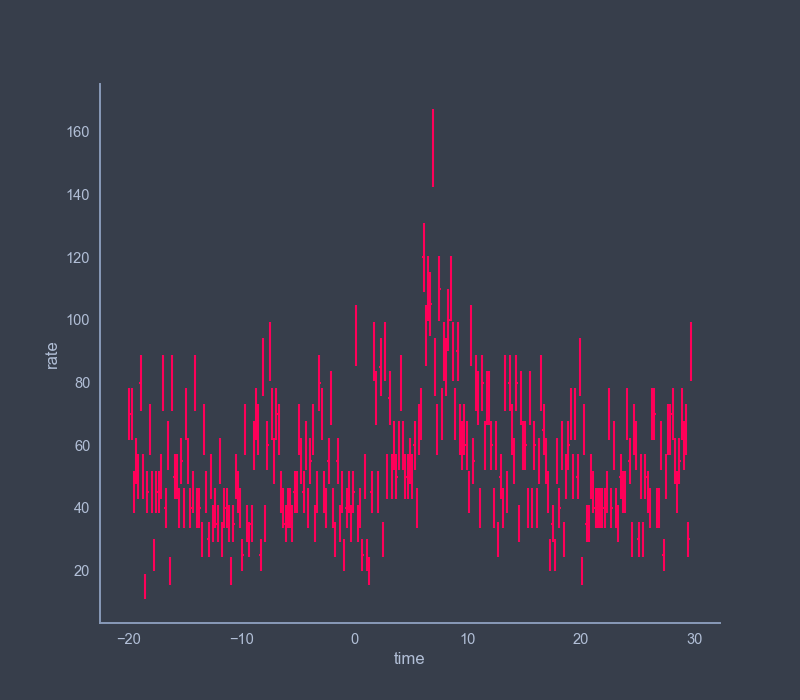

<IPython.core.display.Javascript object>


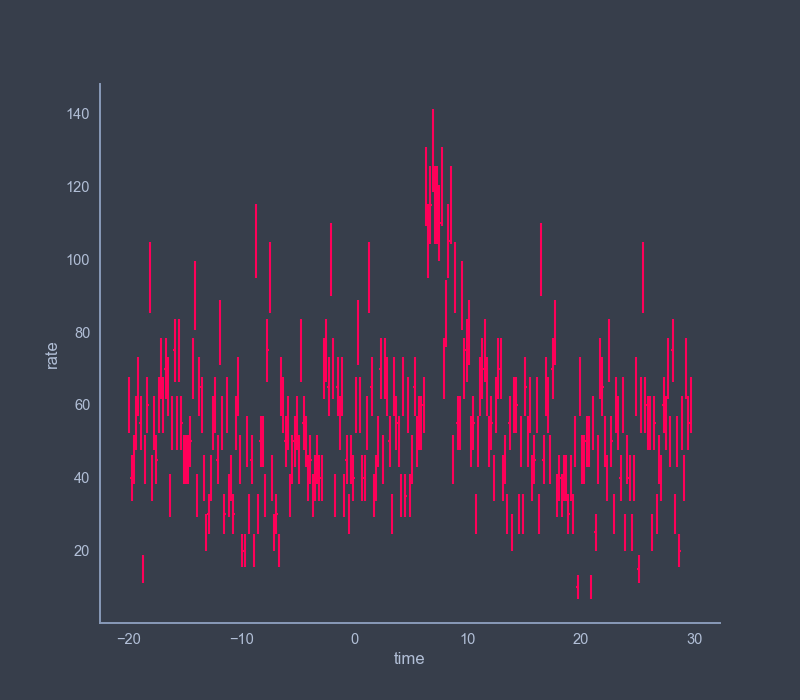

In [12]:

uni = Universe.from_yaml('template_3.yaml')
uni.explode_grb(tstart=-50,tstop=100)
for det, lc in uni.light_curves.items():

    lc.display(-20,30,.2,color=red)



In [13]:
uni._T0

array([0.        , 5.73625728, 5.70399944])

In [16]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-20.4,31.4,.25)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-20,30,.2)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]


lc3 = uni.light_curves['det3']

counts3, times3 = lc3.get_binned_light_curve(-20,30,.2)
mid3 = np.mean([times3[:-1],times3[1:]], axis=0)
width3 = times3[1:] - times3[:-1]

d1 = uni.detectors['det1']
d2 = uni.detectors['det2']
d3 = uni.detectors['det3']

xyz1=d1.location.get_cartesian_coord().xyz.value
xyz2=d2.location.get_cartesian_coord().xyz.value
xyz3=d3.location.get_cartesian_coord().xyz.value


k=50

N_model = 200

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            N3=len(counts3),
            time3=mid3,
            counts3=counts3.astype(int),
            exposure3=width3,
            
            
            k=k,
            bw=.7,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time,
            
            sc_pos1 = xyz1,
            sc_pos2 = xyz2,
             sc_pos3 = xyz3,
           
           
           
           )

In [20]:
model = stan_utility.compile_model('rff_loc3.stan', model_name='rff3')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff3_119358f061f0b31c7a0a9f7bcca8b09f NOW.


In [ ]:
fit = model.sampling(warmup=1500,iter=2000,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=15, adapt_delta=.9)
                    

                    )

<IPython.core.display.Javascript object>


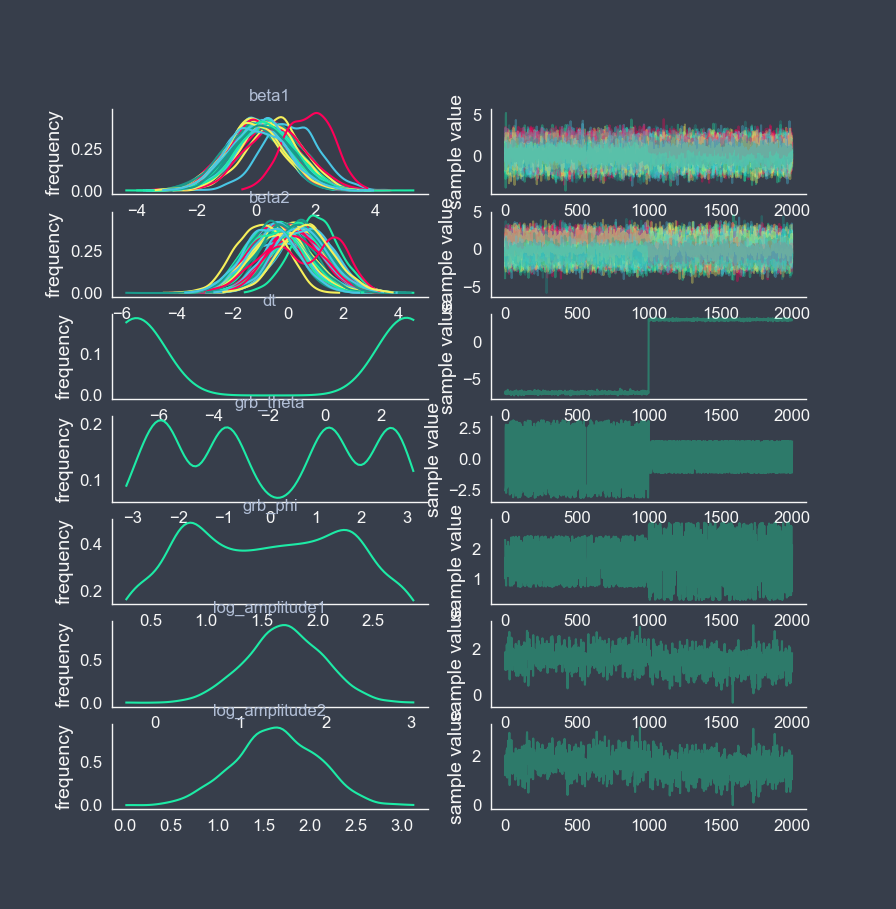

In [17]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt',
              'grb_theta',
              'grb_phi',
              
              'log_amplitude1',
               'log_amplitude2',
            #  'tstart',
         #     'tstop'
             
             ]);

<IPython.core.display.Javascript object>


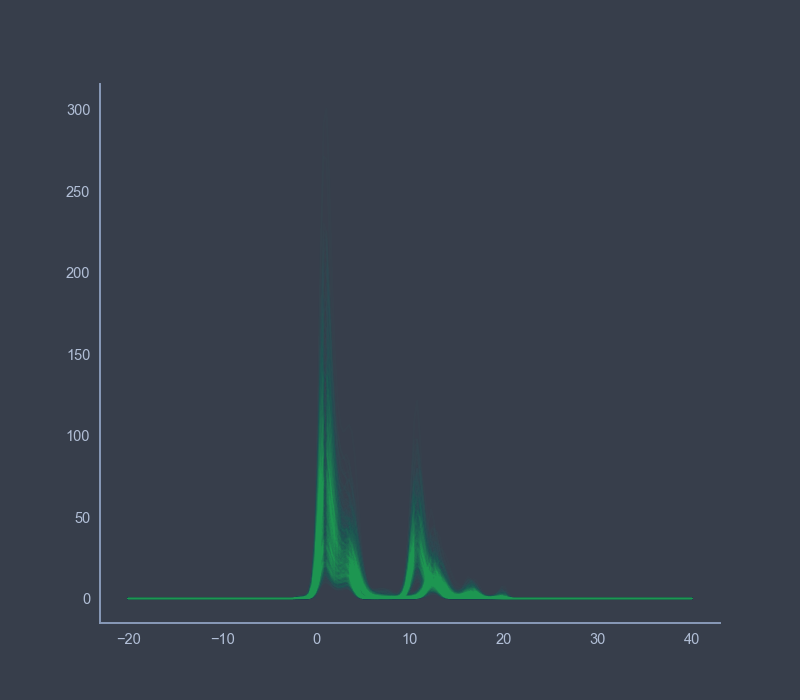

In [18]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::2]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


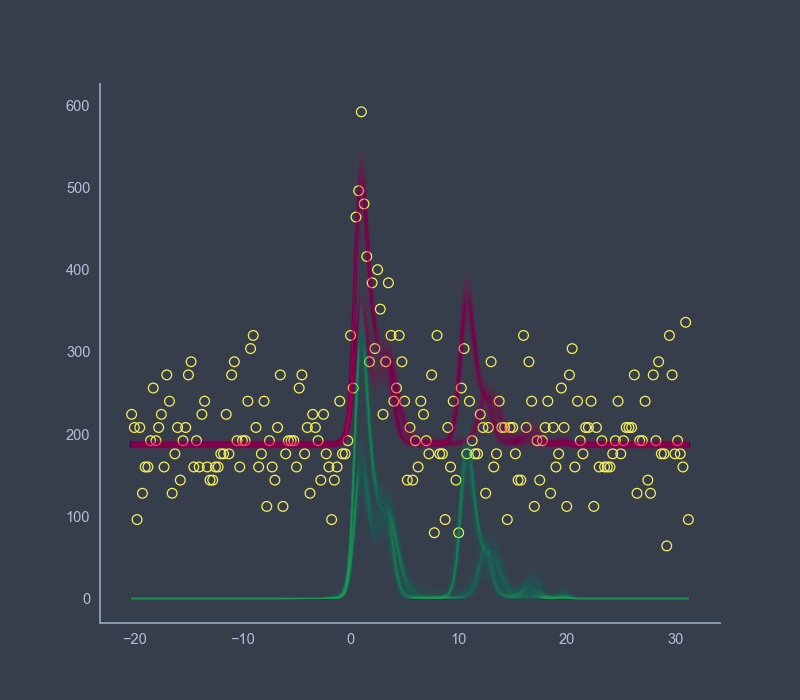

In [19]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts/width, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


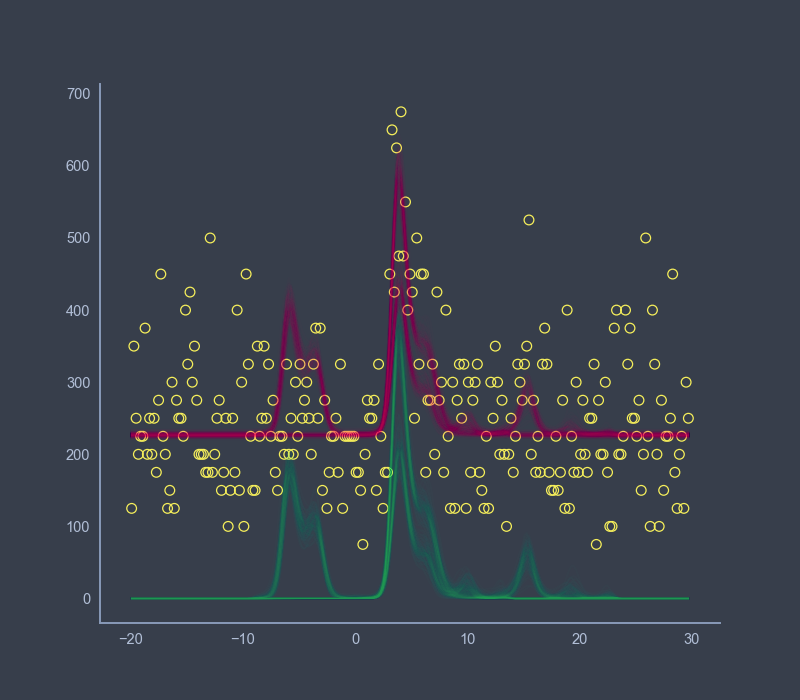

In [20]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2/width2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


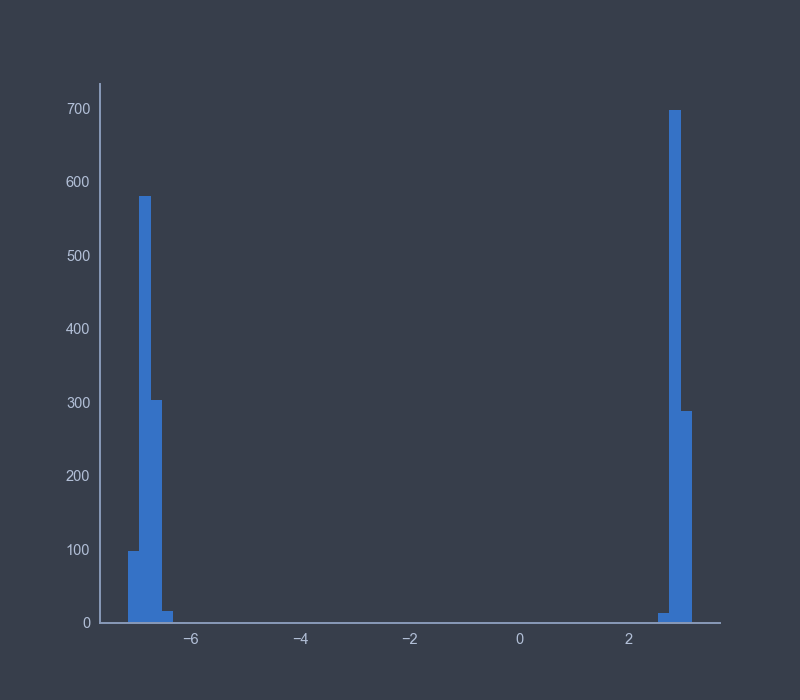

(array([ 98., 581., 303.,  16.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  14., 698., 288.]),
 array([-7.14681632, -6.94064187, -6.73446743, -6.52829298, -6.32211853,
        -6.11594408, -5.90976963, -5.70359519, -5.49742074, -5.29124629,
        -5.08507184, -4.87889739, -4.67272295, -4.4665485 , -4.26037405,
        -4.0541996 , -3.84802515, -3.64185071, -3.43567626, -3.22950181,
        -3.02332736, -2.81715292, -2.61097847, -2.40480402, -2.19862957,
        -1.99245512, -1.78628068, -1.58010623, -1.37393178, -1.16775733,
        -0.96158288, -0.75540844, -0.54923399, -0.34305954, -0.13688509,
         0.06928936,  0.2754638 ,  0.48163825,  0.6878127 ,  0.89398715,
         1.1001616 ,  1.30633604,  1.51251049,  1.71868494,  1.92485939,
 

In [21]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

<IPython.core.display.Javascript object>


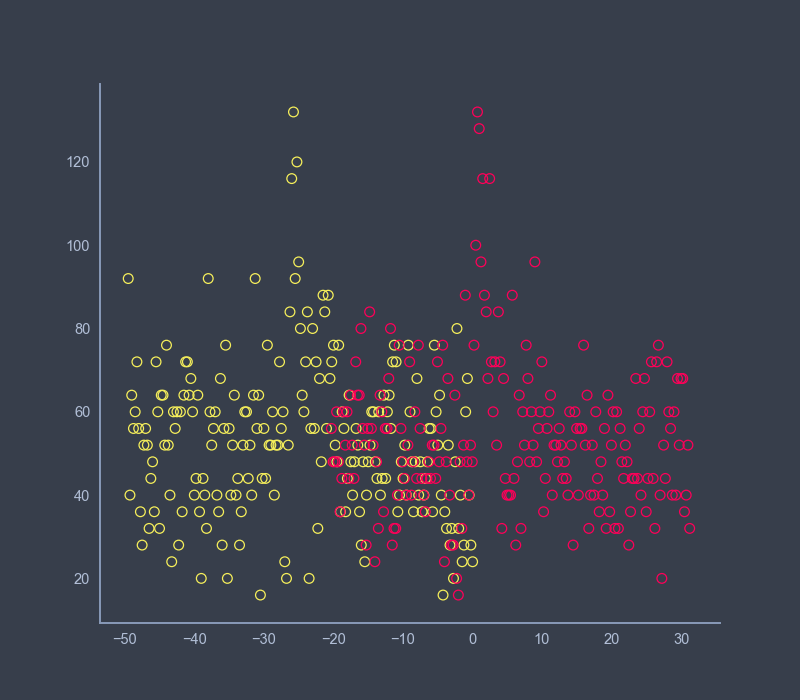

In [26]:
fig, ax = plt.subplots()

dt = 29.6


ax.scatter(mid2 -dt, counts2 , edgecolor=yellow, facecolor='none',lw=.9)
ax.scatter(mid, counts , edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


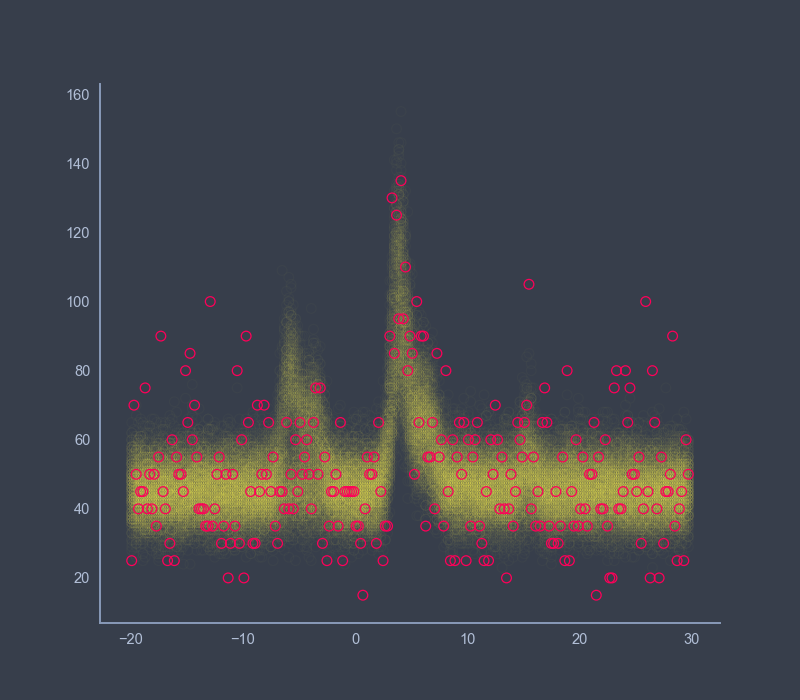

In [140]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


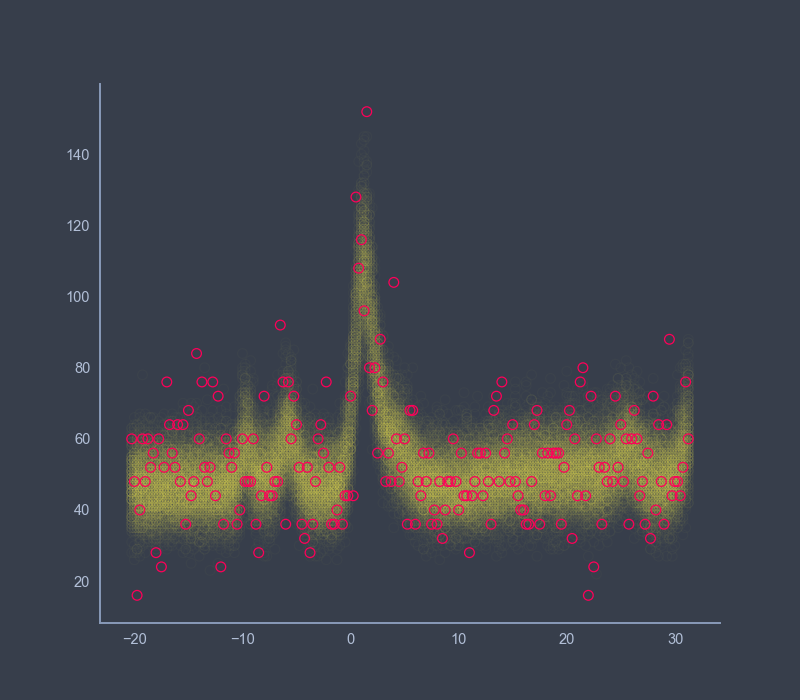

In [40]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


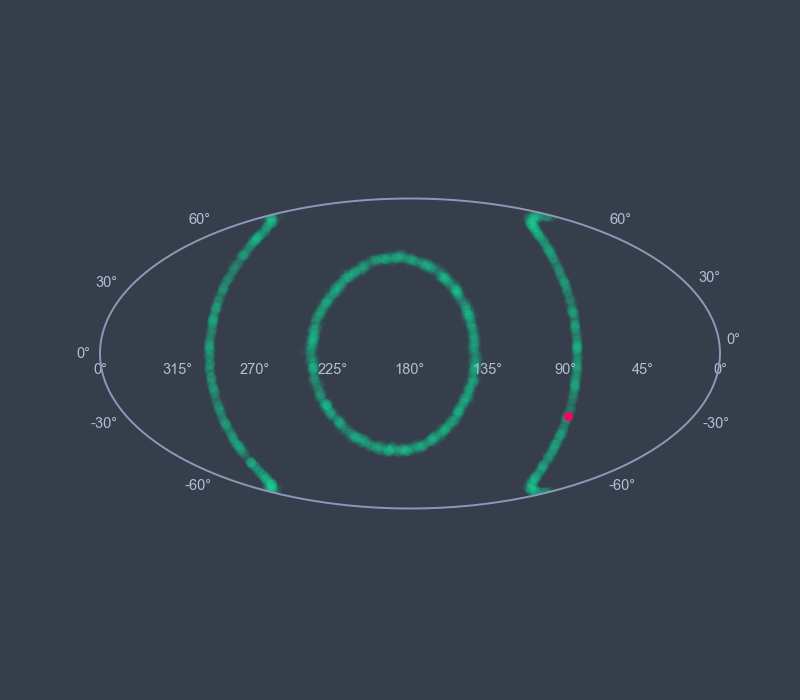

In [135]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))

theta = np.rad2deg(fit.extract('grb_theta')['grb_theta'])
phi = np.rad2deg(fit.extract('grb_phi')['grb_phi'])



idx = theta <= 0

theta[idx] +=360


ax.scatter(theta, phi-90, c=green, alpha=.05,transform=ax.get_transform("icrs"),s=15)
ax.scatter(np.array([80.]),np.array([-30.]),c=red, s=40,transform=ax.get_transform("icrs"))



In [24]:
from pyipn.io.plotting.projection import *

<IPython.core.display.Javascript object>


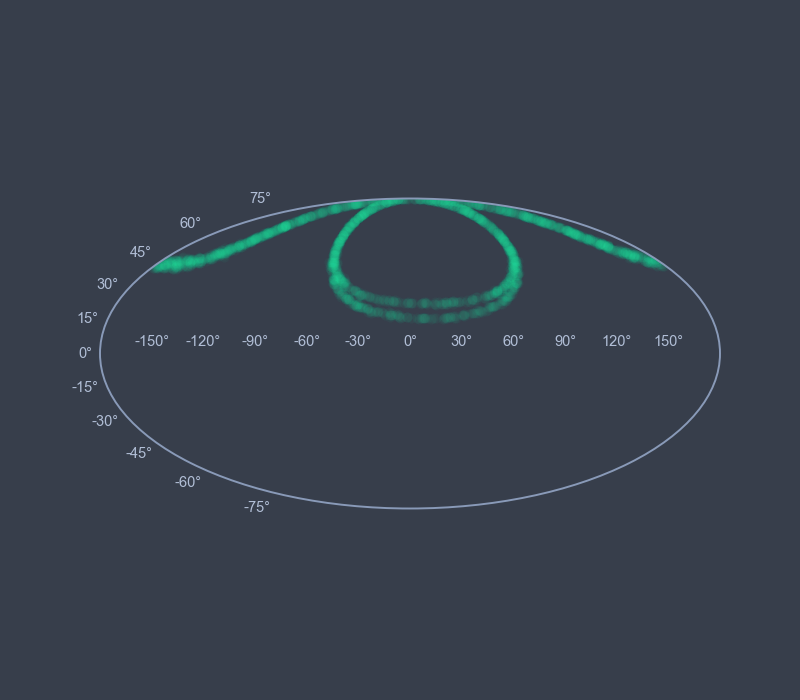

/home/jburgess/.venv/pyipn/local/lib/python3.6/site-packages/matplotlib/projections/geo.py:414: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


In [51]:
fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'))

theta = fit.extract('grb_theta')['grb_theta']
phi = fit.extract('grb_phi')['grb_phi']




ax.scatter(theta, phi, c=green, alpha=.05,)



<IPython.core.display.Javascript object>


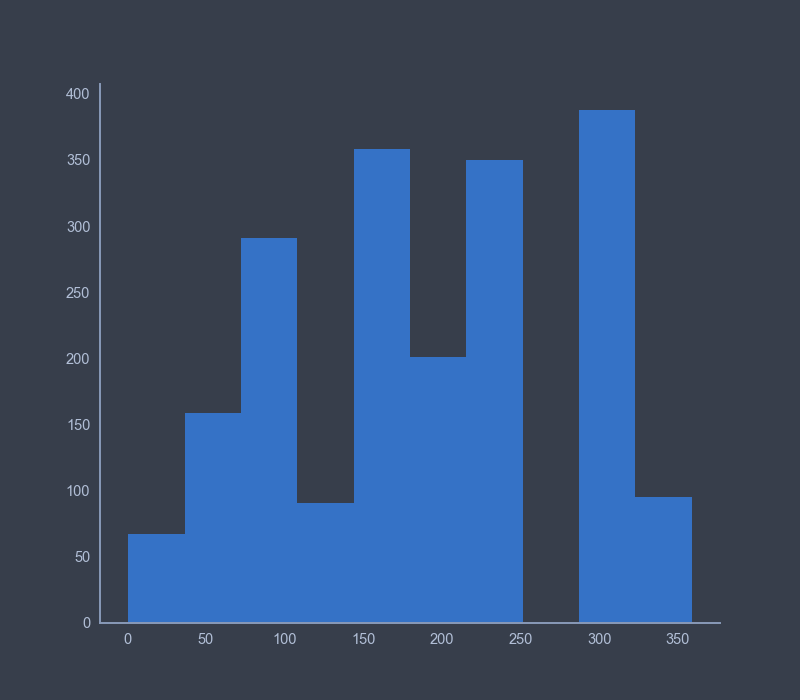

(array([ 67., 159., 291.,  91., 358., 201., 350.,   0., 388.,  95.]),
 array([  0.64329889,  36.46063968,  72.27798046, 108.09532125,
        143.91266203, 179.73000282, 215.5473436 , 251.36468439,
        287.18202518, 322.99936596, 358.81670675]),
 <a list of 10 Patch objects>)

In [28]:
fig, ax = plt.subplots()


ax.hist(theta)


In [138]:

from pyipn.geometry import Location
from pyipn.io.plotting.spherical_circle import SphericalCircle
def compute_annulus_from_time_delay(time_delay, detector1, detector2, ax =None ):
    
    dxyz = (  detector2.location.get_cartesian_coord().xyz - detector1.location.get_cartesian_coord().xyz)
            
    dcart = Location(
    SkyCoord(
        x=dxyz[0],
        y=dxyz[1],
        z=dxyz[2],
        representation_type="cartesian",
        unit="km",
        frame='icrs'
    )
        )
    
    
    norm_d = dcart.get_norm_vec(u.km)
    
    distance = np.linalg.norm(dxyz) * u.km
    
    theta = np.arccos(
            np.around(((-const.c * time_delay*u.s ).to('km')/ distance).value, 15)
        )
    
    
    ra = dcart.coord.represent_as(UnitSphericalRepresentation).lon
    dec = dcart.coord.represent_as(UnitSphericalRepresentation).lat
    
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
    
    circle = SphericalCircle(
            np.array([ra.value, dec.value]) * ra.unit,
            theta*u.rad,
            vertex_unit=u.deg,
            resolution=5000,
            edgecolor=green,
            facecolor="none",
            transform=ax.get_transform("icrs"),
        alpha=.05
  
        )
    
    
   
    
    ax.add_patch(circle)
    
    
    
    
    
    
    
    
    
    
    
    
    
    

<IPython.core.display.Javascript object>


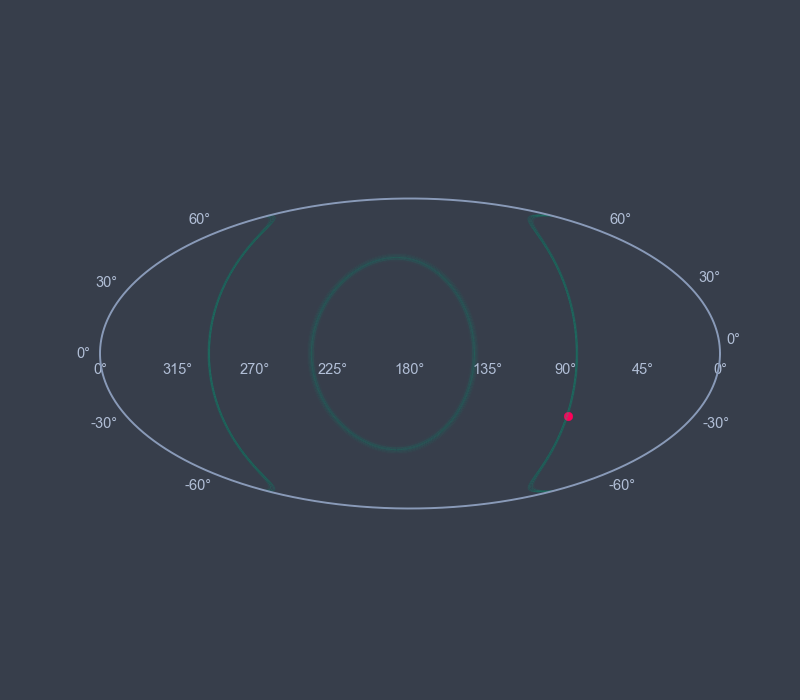

<IPython.core.display.Javascript object>


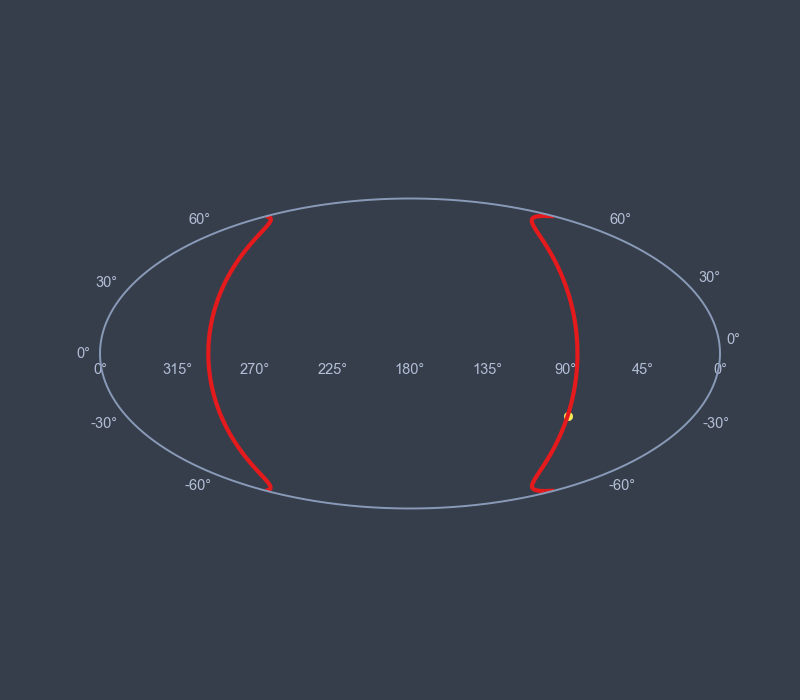

In [139]:

dt = fit.extract('dt')['dt']
fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
for d in dt[::20]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
    
    
ax.scatter(np.array([80.]),np.array([-30.]),c=red, s=40,transform=ax.get_transform("icrs"))

fig2 = uni.plot_all_annuli(lw=3);


ax2 = fig2.get_axes()[0]
ax2.scatter(np.array([80.]),np.array([-30.]),c=yellow, s=40,transform=ax.get_transform("icrs"))

<IPython.core.display.Javascript object>


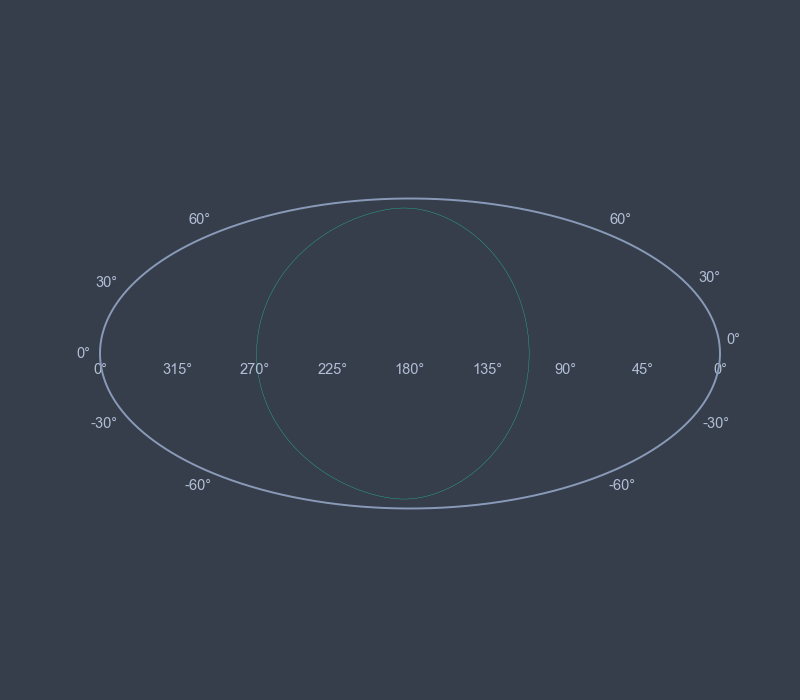

In [132]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))


compute_annulus_from_time_delay(1.9, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
   

In [129]:
uni._T0

array([0.        , 2.96784228])